In [1]:
from __future__ import print_function
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.callbacks import TensorBoard
from tqdm import tqdm
import numpy as np
from bert4keras.backend import keras, K
from bert4keras.layers import Loss
from bert4keras.models import build_transformer_model
from bert4keras.tokenizers import Tokenizer, load_vocab, SpTokenizer
from bert4keras.optimizers import Adam
from bert4keras.snippets import sequence_padding, is_string
from bert4keras.snippets import DataGenerator, AutoRegressiveDecoder
from keras.models import Model
import random
import cv2

Using TensorFlow backend.


In [2]:
# 模型配置
maxlen = 128
batch_size = 15
epochs = 100

# VGG or ResNet
CNN_model = "VGG"

# 是否重新訓練，或是載入訓練好的模型
train_model = False

In [3]:
# 讀取 BERT設定以及詞表
config_path = './uncased_L-12_H-768_A-12/bert_config.json'
checkpoint_path = './uncased_L-12_H-768_A-12/bert_model.ckpt'
dict_path = './uncased_L-12_H-768_A-12/vocab.txt'

In [4]:
# 讀取以及簡化詞表
token_dict, keep_tokens = load_vocab(
    dict_path=dict_path,
    simplified=True,
    startswith=['[PAD]', '[UNK]', '[CLS]', '[SEP]'],
)
tokenizer = Tokenizer(token_dict, do_lower_case=True)

In [5]:
#讀取 IU_XAY 的文字描述，刪除不必要的空白，以及將文字轉換成小寫

def read_train_caption(data):

    images = {}
    
    for i in tqdm(range(len(data))):

        if pd.isnull(data["findings"][i]) == False:
            images[data["filename"][i]] = {
                'image_id': data["filename"][i],
                'caption': (str(data["impression"][i])+str(data["findings"][i])).replace('   ', ' ').replace('  ', ' ').replace('. .', '.').replace('..', '.').lower(),
                'path': "./images/images_normalized/"+str(data["filename"][i])
            }

        elif pd.isnull(data["impression"][i]) == False:
            images[data["filename"][i]] = {
                'image_id': data["filename"][i],
                'caption': str(data["impression"][i]).replace('   ', ' ').replace('  ', ' ').replace('. .', '.').replace('..', '.').lower(),
                'path': "./images/images_normalized/"+str(data["filename"][i])
            }
        else:
            pass

    return list(images.values())


In [6]:
#讀取影像並將非正方圖形，使用黑色將其補為正方形

def read_image(f):

    img = cv2.imread(f)
    height, width = img.shape[:2]
    if height > width:
        height, width = img_size, width * img_size // height
        img = cv2.resize(img, (width, height))
        delta = (height - width) // 2
        img = cv2.copyMakeBorder(
            img,
            top=0,
            bottom=0,
            left=delta,
            right=height - width - delta,
            borderType=cv2.BORDER_CONSTANT,
            value=[0, 0, 0]
        )
    else:
        height, width = height * img_size // width, img_size
        img = cv2.resize(img, (width, height))
        delta = (width - height) // 2
        img = cv2.copyMakeBorder(
            img,
            top=delta,
            bottom=width - height - delta,
            left=0,
            right=0,
            borderType=cv2.BORDER_CONSTANT,
            value=[0, 0, 0]
        )
    img = img.astype('float32')
    return img[..., ::-1]  # BGR轉 RGB

In [7]:
class data_generator(DataGenerator):
#將影像以及資料整理成可供模型訓練的格式
    def __iter__(self, random=False):
        batch_images, batch_token_ids, batch_segment_ids = [], [], []
        for is_end, D in self.sample(random):
            img = D['path']
            caption = D['caption']
            token_ids, segment_ids = tokenizer.encode(caption, max_length=maxlen)
            batch_images.append(read_image(img))
            batch_token_ids.append(token_ids)
            batch_segment_ids.append(segment_ids)
            if len(batch_token_ids) == self.batch_size or is_end:
                batch_images = np.array(batch_images)
                batch_images = preprocess_input(batch_images)
                batch_token_ids = sequence_padding(batch_token_ids)
                batch_segment_ids = sequence_padding(batch_segment_ids)
                yield [batch_token_ids, batch_segment_ids, batch_images], None
                batch_images, batch_token_ids, batch_segment_ids = [], [], []

In [8]:
#讀取整理好的 CSV檔案，其中使用 findgind & impression欄位共大於15字才列入訓練資料

train_ = pd.read_csv("./count15_train.csv")
test_  = pd.read_csv("./count15_test.csv")


In [9]:
train_data = read_train_caption(train_)
test_data  = read_train_caption(test_ )
len(train_data),len(test_data)


100%|█████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 12843.59it/s]


(6490, 500)

In [10]:
class CrossEntropy(Loss):
    """mask掉padding部分
    """
    def compute_loss(self, inputs, mask=None):
        y_true, y_pred = inputs
        if mask[1] is None:
            y_mask = 1.0
        else:
            y_mask = K.cast(mask[1], K.floatx())[:, 1:]
        y_true = y_true[:, 1:]  # 目標token_ids
        y_pred = y_pred[:, :-1]  # 預測序列，錯開一列
        loss = K.sparse_categorical_crossentropy(y_true, y_pred)
        loss = K.sum(loss * y_mask) / K.sum(y_mask)
        return loss



In [11]:
#使用 pre-trained CNN model 作為影像特徵的擷取

if CNN_model == "VGG":
    MobileNetV2      = keras.applications.vgg19.VGG19
    preprocess_input = keras.applications.vgg19.preprocess_input
else:
    MobileNetV2      = keras.applications.resnet_v2.ResNet152V2
    preprocess_input = keras.applications.resnet_v2.ResNet152V2
    
    
image_model = MobileNetV2(include_top=False, pooling='avg')
img_size = 224

In [19]:
# Bert模型
model = build_transformer_model(
    config_path,
    checkpoint_path,
    application='lm',
    keep_tokens=keep_tokens,  # 只保留keep_tokens中的字，精簡字表
    layer_norm_cond=image_model.output,
    layer_norm_cond_hidden_size=128,
    layer_norm_cond_hidden_act='swish',
    additional_input_layers=image_model.input,
)

output = CrossEntropy(1)([model.inputs[0], model.outputs[0]])

model = Model(model.inputs, output)
model.compile(optimizer=Adam(1e-5))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
____________________________________________________________________________________________

C:\Users\user\AppData\Roaming\Python\Python36\site-packages\keras\engine\training_utils.py:819: UserWarning: Output cross_entropy_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to cross_entropy_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [20]:
#使用 Transformer作為 Decoder，使用 beam search top_k = 3

class AutoCaption(AutoRegressiveDecoder):

    @AutoRegressiveDecoder.set_rtype('probas')
    def predict(self, inputs, output_ids, step):
        image = inputs[0]
        token_ids = output_ids
        segment_ids = np.zeros_like(token_ids)
        return model.predict([token_ids, segment_ids, image])[:, -1]

    def generate(self, image, topk=3):
        if is_string(image):
            image = read_image(image)
        image = preprocess_input(image)
        output_ids = self.beam_search([image], topk)  # beam search top_k = 3
        return tokenizer.decode(output_ids)


autocaption = AutoCaption(
    start_id=tokenizer._token_start_id,
    end_id=tokenizer._token_end_id,
    maxlen=maxlen
)

In [21]:
from PIL import Image
from rouge import Rouge  # pip install rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

##just show 用於訓練時即時顯示初步的訓練結果以及影像

def just_show():
    samples = [test_data[i] for i in np.random.choice(len(test_data), 10)]
    bleu_1,total = 0, 0
    for D in samples:
        total += 1
        img = D['path']
        temp_image = np.array(Image.open(img))
        fig = plt.figure(figsize=(10, 10))
        #ax  =fig.set_title(D['image_id'])
        capa = autocaption.generate(img)
        pred_title = ' '.join(capa)
        title = ' '.join(D["caption"])
        print(u'image_id:', D['image_id'])
        print(u'predict:')
        print(capa)
        print()
        print(u'references:')
        print(D['caption'])
        print()
        if pred_title.strip():
            #scores = Rouge().get_scores(hyps=pred_title, refs=title)
            #rouge_1 += scores[0]['rouge-1']['f']
            #rouge_2 += scores[0]['rouge-2']['f']
            #rouge_L += scores[0]['rouge-l']['f']
            bleu_1  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(1.0, 0, 0, 0)
            )


        bleu_1  /= total
        print('bleu_1:', bleu_1)
        print()
        bleu_1,total = 0, 0
        plt.axis("off")
        plt.imshow(temp_image,cmap="gray")
        plt.tight_layout()
        plt.show()

In [22]:
class Evaluate(keras.callbacks.Callback):
    def __init__(self):
        self.lowest = 1e10

    def on_epoch_end(self, epoch, logs=None):
        # 儲存權重
        if logs['loss'] <= self.lowest:
            self.lowest = logs['loss']
            model.save_weights('./count15_final.weights')
        # 即時顯示訓練結果
        just_show()
        



In [23]:
len(train_data),len(test_data)

(6490, 500)

In [24]:
steps_per_epoch = len(train_data)//batch_size
evaluator = Evaluate()
train_generator = data_generator(train_data, batch_size)
len(train_generator)

433

In [25]:

#重新訓練模型，或是載入訓練好的模型

if train_model == True:

    train_history = model.fit_generator(
                  train_generator.forfit(),
                  steps_per_epoch=steps_per_epoch,
                  epochs=epochs,
                  callbacks=[evaluator]
    )
    
elif CNN_model == "VGG":
    model.load_weights('./VGG19.weights')

else:
    model.load_weights('./ResNet.weights')

image_id: 425_IM-2068-2001.dcm.png
predict:
no acute cardiopulmonary abnormalities. the heart is normal in size and contour. there is no mediastinal widening. the lungs are clear bilaterally. no large pleural effusion or pneumothorax. the are intact.

references:
no acute cardiopulmonary process.lungs are clear. there is no pneumothorax or pleural effusion. the heart and mediastinum are within normal limits. bony structures are intact.

bleu_1: 0.8135593220338984



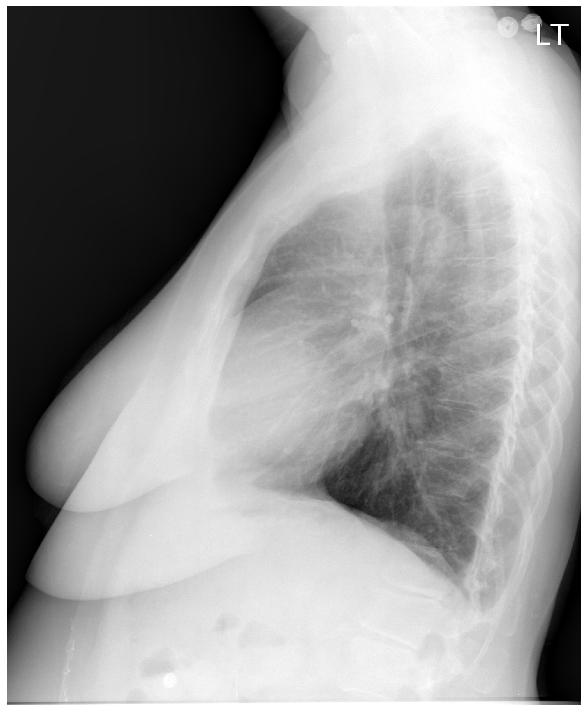

image_id: 2258_IM-0849-1001.dcm.png
predict:
no acute radiographic cardiopulmonary process. the cardiomediastinal silhouette and vasculature are within normal limits for size and contour. the lungs are normally inflated and clear. osseous structures are within normal limits for patient age.

references:
prominent interstitial markings in the central lungs and bases which may be secondary to low lung volumes with bronchovascular crowding, differential considerations include interstitial infiltrates of inflammatory or infectious etiology and mild pulmonary edema. clinical correlation is recommended.mild hypoventilation with bronchovascular crowding and prominent central and basilar interstitial markings. no focal alveolar consolidation, no pleural effusion demonstrated. considering technical factors heart size within normal limits.

bleu_1: 0.31646658031065544



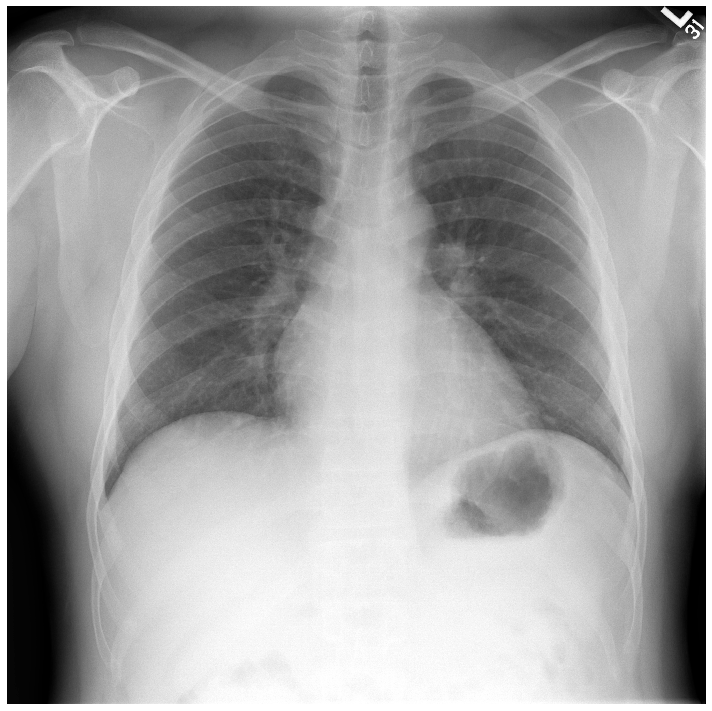

image_id: 2324_IM-0895-1001.dcm.png
predict:
no acute cardiopulmonary abnormality. mediastinal contours are normal. lungs are clear. there is no pneumothorax or large pleural effusion.

references:
negative chest .the lungs are clear. the cardiomediastinal silhouette is within normal limits. no pneumothorax or pleural effusion.

bleu_1: 0.821656050955414



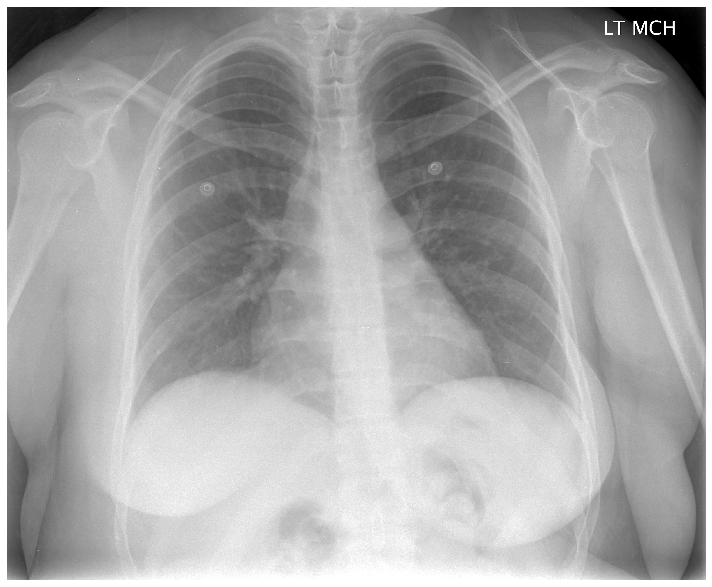

image_id: 2528_IM-1044-1001.dcm.png
predict:
normal chest. heart size and vascularity normal. lungs are clear. no effusions. no pneumothorax. visualized osseous structures unremarkable.

references:
lungs appear relatively clear on today's exam. no significant interval change since the prior study and .the cardiac contours are normal. the lungs are clear. thoracic spondylosis.

bleu_1: 0.6619795209959433



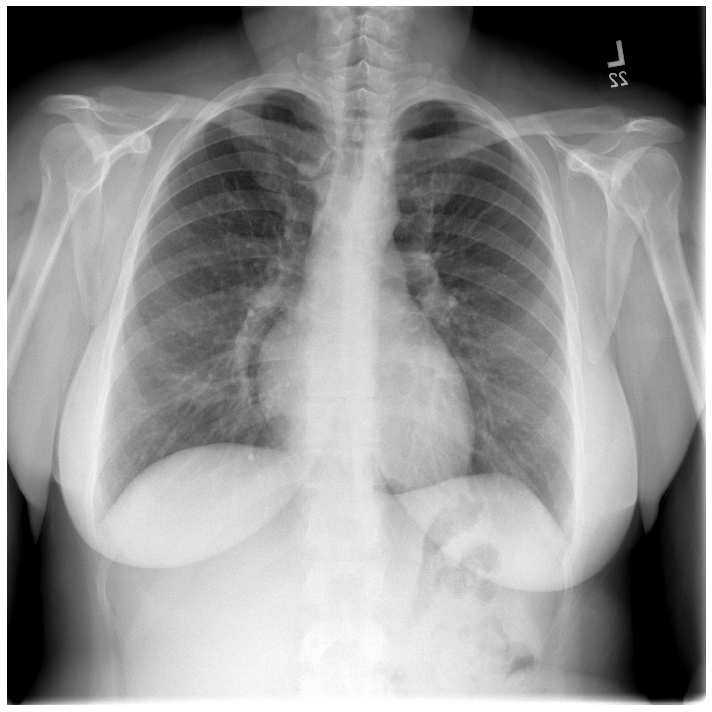

image_id: 2694_IM-1165-2001.dcm.png
predict:
no acute cardiopulmonary findingsheart size within normal limits, stable mediastinal and hilar contours. no alveolar consolidation, no findings of pleural effusion or pulmonary edema. no pneumothorax.

references:
no acute cardiopulmonary disease.the heart is normal in size and contour. the lungs are clear, without evidence of infiltrate. there is no pneumothorax or effusion.

bleu_1: 0.7822222222222223



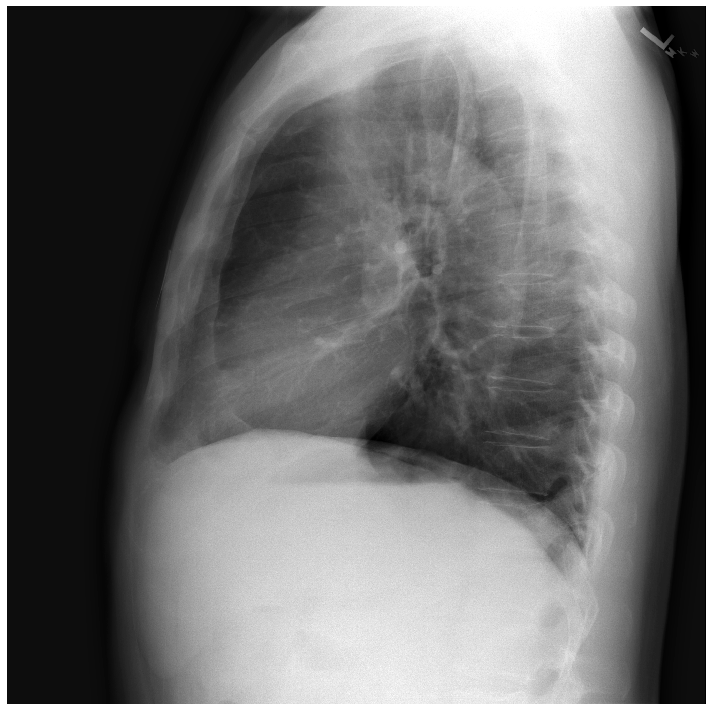

image_id: 1860_IM-0558-2001.dcm.png
predict:
small calcified granulomas. no suspicious appearing lung nodules identified. well-expanded and clear lungs. mediastinal contour within normal limits. no acute cardiopulmonary abnormality identified.

references:
 no evidence of acute cardiopulmonary process. scoliotic curvature of the spine with deformity of the t9 vertebral body.the cardiac and mediastinal silhouettes are normal. the lungs are well-expanded and clear. there is no focal airspace opacity. there is no pneumothorax or effusion. there is dextrocurvature of the thoracic spine. there is deformity of the t9 vertebral body. levocurvature of the lumbar spine with significant degenerative change is also noted.

bleu_1: 0.2421538966973069



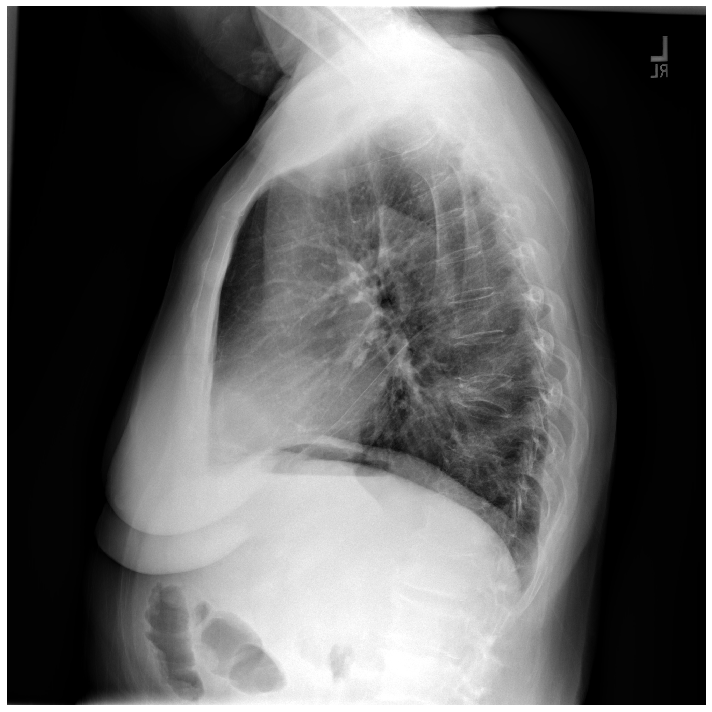

image_id: 1334_IM-0214-1001.dcm.png
predict:
negative for acute cardiopulmonary abnormality. lungs are clear without focal consolidation, effusion, or pneumothorax. normal heart size. bony thorax and soft tissues unremarkable.

references:
no acute cardiopulmonary abnormality.mediastinal contours are normal. lungs are clear. there is no pneumothorax or large pleural effusion.

bleu_1: 0.7536945812807881



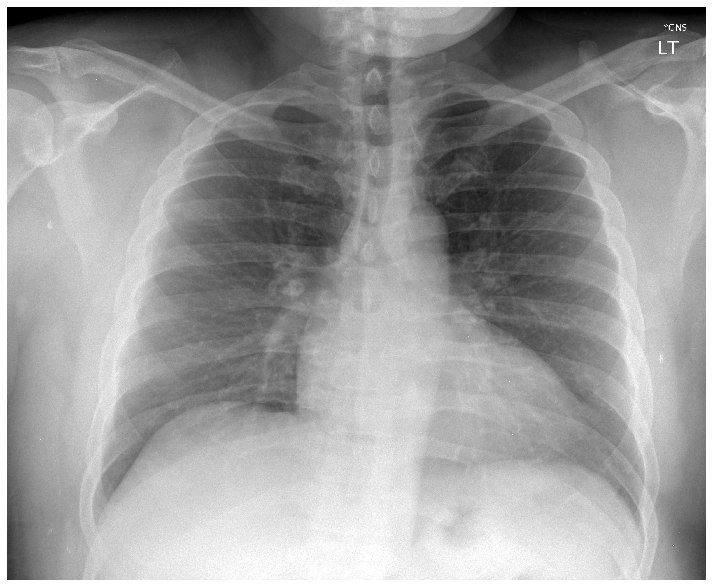

image_id: 3139_IM-1476-2001.dcm.png
predict:
no evidence of active disease. the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen. scoliosis and degenerative changes are present in the spine.

references:
no acute cardiopulmonary abnormality.no focal areas of consolidation. no pleural effusions. no evidence of pneumothorax. heart size within normal limits. osseous structures intact.

bleu_1: 0.6586206896551724



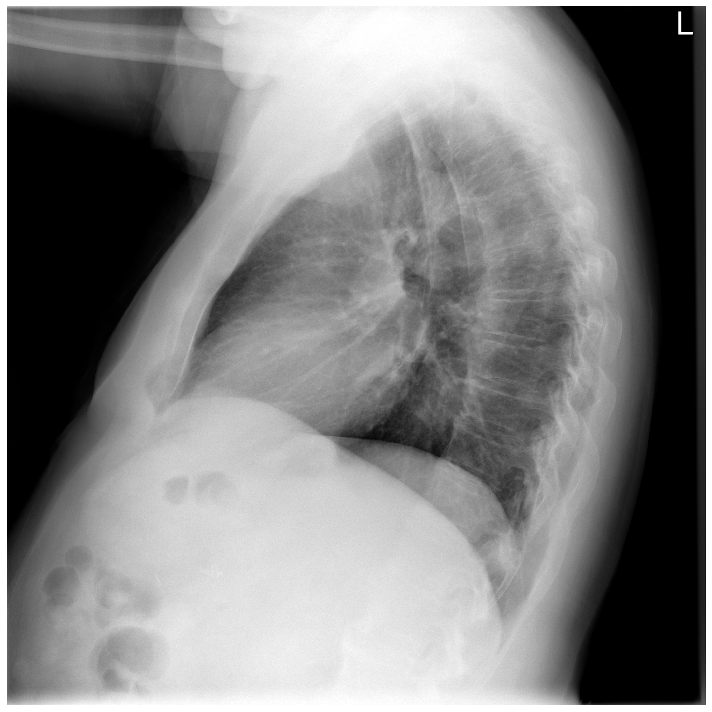

image_id: 3268_IM-1551-1001.dcm.png
predict:
no acute cardiopulmonary process. the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease, pleural effusion, or pneumothorax. no acute bone abnormality.

references:
no acute cardiopulmonary abnormalities.the heart is normal in size and contour. there is no mediastinal widening. the lungs are clear bilaterally. no large pleural effusion or pneumothorax. the are intact.

bleu_1: 0.8091872791519434



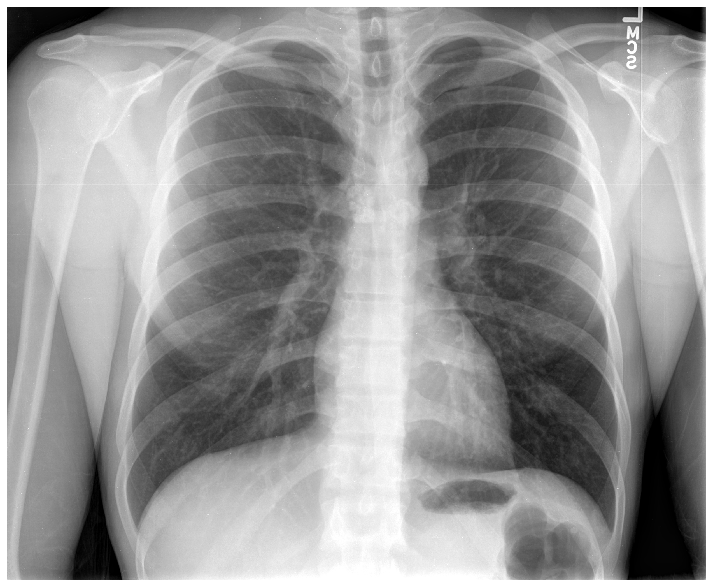

image_id: 3525_IM-1722-6001.dcm.png
predict:
no acute cardiopulmonary findings. cardiomediastinal silhouette and pulmonary vasculature are within normal limits. lungs are clear. no pneumothorax or pleural effusion. no acute osseous findings.

references:
no acute cardiopulmonary abnormality. no fracture visualized.heart size normal. no pneumothorax, pleural effusion, or focal airspace disease. the visualized bony structures appear intact. there is a radiodensity overlying the right shoulder which is external to the patient however clinical correlation recommended. scattered calcified granulomas.

bleu_1: 0.4617520257827378



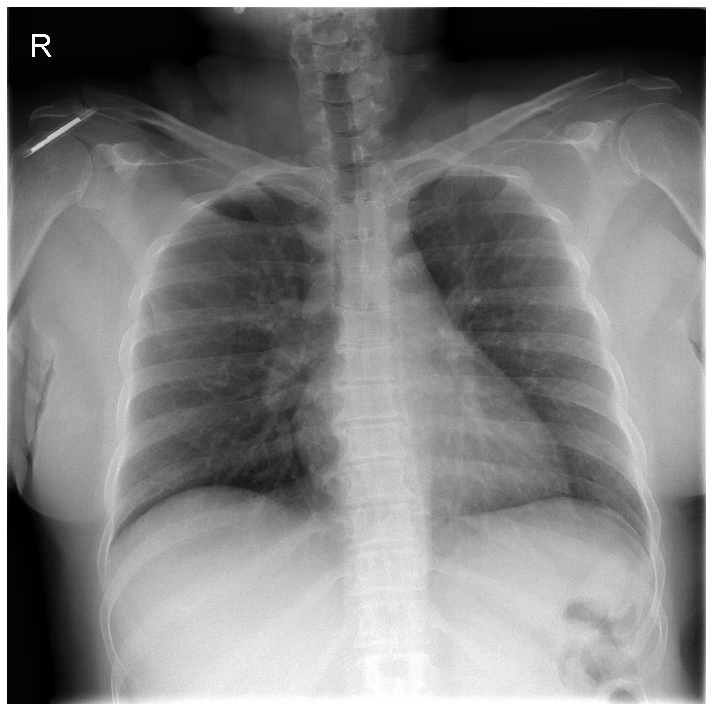

In [26]:
just_show()

In [27]:
from rouge import Rouge  # pip install rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

#將500筆測試資料使用訓練好的模型產生描述，以及平均 500筆資料所得到的最終結果

def Evaluate_test(test_data):
    total = 0
    rouge_1, rouge_2, rouge_L, bleu_1, bleu_2, bleu_3, bleu_4 = 0, 0, 0, 0, 0, 0, 0
    for D in tqdm(test_data):
        total += 1
        title = ' '.join(D["caption"])
        path  = D["path"]
        pred_title = ' '.join(autocaption.generate(path))
        if pred_title.strip():
            scores = Rouge().get_scores(hyps=pred_title, refs=title)
            rouge_1 += scores[0]['rouge-1']['f']
            rouge_2 += scores[0]['rouge-2']['f']
            rouge_L += scores[0]['rouge-l']['f']
            bleu_1  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(1.0, 0, 0, 0)
            )
            bleu_2  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(0.5, 0.5, 0, 0)
            )
            bleu_3  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(0.33, 0.33, 0.33, 0)
            )
            bleu_4  += sentence_bleu(
                references=[title.split(' ')],
                hypothesis=pred_title.split(' '),
                smoothing_function=SmoothingFunction().method1,
                weights=(0.25, 0.25, 0.25, 0.25)
            )
    rouge_1 /= total
    rouge_2 /= total
    rouge_L /= total
    bleu_1  /= total
    bleu_2  /= total      
    bleu_3  /= total
    bleu_4  /= total
    return {
        'rouge-1': rouge_1,
        'rouge-2': rouge_2,
        'rouge-L': rouge_L,
        'bleu_1': bleu_1,
        'bleu_2': bleu_2,
        'bleu_3': bleu_3,
        'bleu_4': bleu_4,
    }

In [28]:
Evaluate_test(test_data)

 18%|██████████████▋                                                                  | 91/500 [08:32<45:21,  6.65s/it]

KeyboardInterrupt: 

In [ ]:
# {'rouge-1': 0.7427328228671284,
#  'rouge-2': 0.5156309405646707,
#  'rouge-L': 0.8013772981050383,
#  'bleu_1': 0.6234953244647322,
#  'bleu_2': 0.5428699841912354,
#  'bleu_3': 0.4717806408362671,
#  'bleu_4': 0.408735648244}

In [ ]:
#VGG19
# {'rouge-1': 0.7631935592783027,
#  'rouge-2': 0.5476986859718332,
#  'rouge-L': 0.8697064935552393,
#  'bleu_1': 0.6360720082828326,
#  'bleu_2': 0.5605016827267579,
#  'bleu_3': 0.496913063275716,
#  'bleu_4': 0.4404597244514299}